# Research Question

1. How do rating distributions from users and gaming media compare across different price tiers, and what does this reveal about valuation of games at various price points?

2. Is there a significant difference in gamers and gaming media ratings across different game categories, and how does this vary between indie and non-indie games?

3. Is there a significant difference in how gamers and gaming media rate indie games compared to non-indie games across different levels of popularity as measured by total review counts?

In [1]:
import os
import altair as alt
import pandas as pd
from toolz.curried import pipe
import numpy as np
import ast

# Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

In [2]:
# Dataset loading and filtering
path = '../../data/processed/cleaned_games.csv'
data = pd.read_csv(path)

filtered_columns = ['name', 'developers','categories','genres','release_date', 
                    'total_reviews', 'total_positive', 'total_negative', 
                    'review_score', 'review_score_desc', 'positive_percentual', 
                    'metacritic', 'price_initial (USD)']

games_filtered = data[filtered_columns]

# Filter games that have more than 50 reviews
games_filtered = games_filtered[games_filtered['total_reviews'] >= 50]

# Convert metacritic to float
games_filtered['metacritic'] = games_filtered['metacritic'].astype(float)

# Convert metacritic unit to the same as review_score's
games_filtered['metacritic'] = games_filtered['metacritic'] / 10

# Replace Metacritic 
games_filtered['metacritic'] = games_filtered['metacritic'].replace(0.0, pd.NA)

# Divide price into four groups
bins = [0, 1, 10, 30, float('inf')]
labels = ['Free (0)', 'Low (0-10)', 'Medium (10-30)', 'High (>30)']
games_filtered['price_group'] = pd.cut(games_filtered['price_initial (USD)'], 
                                       bins=bins, labels=labels, right=False)

# Process list columns
columns_to_process = ['developers','categories', 'genres']
for col in columns_to_process:
    games_filtered[col] = games_filtered[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Check if the game is indie
games_filtered['is_indie'] = games_filtered['genres'].apply(lambda x: 'Indie' if 'Indie' in x else 'Non-Indie')

In [3]:
# Brush selection for scatterplot

scatter_brush = alt.selection_interval(name="scatter_brush")

In [4]:
# Range Slider for total reviews


review_count_slider = alt.param(
    name='min_review_count',
    value=50,  # Default value
    bind=alt.binding_range(
        min=50,
        max=800,
        step=10,
        name='Min Review Count: '
    )
)

In [5]:
# Radio buttons for indie/non-indie filter

options = ['Indie', 'Non-Indie']
labels = [option + ' ' for option in options]

indie_dropdown = alt.binding_radio(
    # Add the empty selection which shows all when clicked
    options=options + [None],
    labels=labels + ['All'],
    name='Genre: '
)
indie_selection = alt.selection_point(
    fields=['is_indie'],
    bind=indie_dropdown,
)

In [6]:
# Range Slider for year

games_filtered['release_year'] = pd.to_datetime(games_filtered['release_date']).dt.year

release_year_slider = alt.param(
    name='release_year',
    value=1997,
    bind=alt.binding_range(
        min=1997,
        max=2025,
        step=1,
        name='Release Year: '
    )
)

In [7]:
# Hover Selection

hover_cat = alt.selection_point(
    fields=['categories'],
    on='mouseover',
    nearest=True,
    empty='none'
)

In [24]:
# Gamers Review Violin Plot
violin_review = alt.Chart(games_filtered).transform_filter(
    scatter_brush
).transform_filter(
    indie_selection  
).transform_density(
    'review_score',
    as_=['review_score', 'density'],
    extent=[1,10],
    groupby=['price_group']
).mark_area(orient='horizontal').encode(
    y=alt.Y('review_score:Q', title="Gamer Review Score"),
    x=alt.X('density:Q', stack='center', impute=None, title=None, axis=None),
    color=alt.Color('price_group:N', legend=None),
    column=alt.Column('price_group:N', sort=['Free (0)', 'Low (0-10)', 'Medium (10-30)', 'High (>30)'],
                spacing=0,
                header=alt.Header(titleOrient='bottom', labelOrient='bottom', labelPadding=0)),
    tooltip=['price_group', 'review_score']
).properties(
    title='Violin Plot of Gamer Ratings by Price Group',
    height=225,
    width=225
)

In [25]:
# Media Review Violin Plot
violin_metacritic = alt.Chart(games_filtered).transform_filter(
    scatter_brush
).transform_filter(
    indie_selection  
).transform_density(
    'metacritic',
    as_=['metacritic', 'density'],
    extent=[1,10],
    groupby=['price_group']
).mark_area(orient='horizontal').encode(
    y=alt.Y('metacritic:Q', title="Media Review Score"),
    x=alt.X('density:Q', stack='center', impute=None, title=None, axis=None),
    color=alt.Color('price_group:N'),
    column=alt.Column('price_group:N', sort=['Free (0)', 'Low (0-10)', 'Medium (10-30)', 'High (>30)'],
                spacing=0,
                header=alt.Header(titleOrient='bottom', labelOrient='bottom', labelPadding=0)),
    tooltip=['price_group', 'metacritic']
).properties(
    title='Violin Plot of Media Ratings by Price Group',
    height=225,
    width=225
)

In [26]:
violin_final = alt.vconcat(violin_review, violin_metacritic)

In [11]:
games_exploded = games_filtered.explode('categories')


category_avg_gamer = games_exploded.groupby(['categories','is_indie'])[['review_score']].mean().reset_index()

category_avg_media = games_exploded.groupby(['categories','is_indie'])[['metacritic']].mean().reset_index()

bar_chart_gamer = alt.Chart(category_avg_gamer).mark_bar().encode(
    x = alt.X('categories:N', title='Game Categories', sort='-y',axis=alt.Axis(labelAngle=45)),
    y = alt.Y('review_score:Q', title='Average Gamer Review Score'),
    color=alt.Color('is_indie:N', title='Rating Type'),
    tooltip=['categories', 'review_score', 'is_indie'],
    strokeWidth=alt.condition(hover_cat, alt.value(4), alt.value(1)),
    opacity=alt.condition(hover_cat, alt.value(1), alt.value(0.7))
).properties(
    title='Average Gamers Game Ratings by Category',
    width=350,
    height=150    
).transform_filter(
    indie_selection
).add_params(
    indie_selection,
    hover_cat
)

bar_chart_media = alt.Chart(category_avg_media).mark_bar().encode(
    x = alt.X('categories:N', title='Game Categories', sort='-y',axis=alt.Axis(labelAngle=45)),
    y = alt.Y('metacritic:Q', title='Average Media Review Score'),
    color=alt.Color('is_indie:N', title='Rating Type'),
    tooltip=['categories', 'metacritic', 'is_indie'],
    strokeWidth=alt.condition(hover_cat, alt.value(4), alt.value(1)),
    opacity=alt.condition(hover_cat, alt.value(1), alt.value(0.7))
).properties(
    title='Average Media Game Ratings by Category',
    width=400,
    height=150    
).transform_filter(
    indie_selection
).add_params(
    indie_selection,
    hover_cat
)

In [12]:
bar_final = alt.hconcat(bar_chart_gamer, bar_chart_media)

In [13]:
# Scatter Plot：Gamer Review vs. Total Reviews
scatter_review = alt.Chart(games_filtered).mark_circle(size=60, opacity=0.6).encode(
    x=alt.X('total_reviews:Q', title='Total Reviews', scale=alt.Scale(type='log')),
    y=alt.Y('review_score:Q', title='Gamer Review Score', scale=alt.Scale(domain=[0, 10])),
    color=alt.condition(
        scatter_brush,
        alt.Color('is_indie:N', title='Game Type'),
        alt.value('lightgray')  
    ),
    opacity=alt.condition(
        alt.datum.total_reviews >= review_count_slider, 
        alt.value(0.9), 
        alt.value(0.2)   
    ),
    tooltip=['name', 'is_indie', 'review_score', 'total_reviews']
).properties(
    title='User Review Score vs. Total Reviews',
    width=375,
    height=225
).add_params(
    scatter_brush,
    indie_selection,
    review_count_slider,
    release_year_slider
).transform_filter(
    indie_selection,
    alt.datum.total_reviews >= review_count_slider
).transform_filter(
    alt.datum.release_year >= release_year_slider
)

# Scatter Plot：Media Review vs. Total Reviews
scatter_media = alt.Chart(games_filtered).mark_circle(size=60, opacity=0.6).encode(
    x=alt.X('total_reviews:Q', title='Total Reviews', scale=alt.Scale(type='log')),
    y=alt.Y('metacritic:Q', title='Media Score (0-10)', scale=alt.Scale(domain=[0, 10])),
    color=alt.condition(
        scatter_brush,  
        alt.Color('is_indie:N', title='Game Type'),
        alt.value('lightgray')  
    ),
    opacity=alt.condition(
        alt.datum.total_reviews >= review_count_slider, 
        alt.value(0.9), 
        alt.value(0.2)   
    ),
    tooltip=['name', 'is_indie', 'metacritic', 'total_reviews']
).properties(
    title='Metacritic Score vs. Total Reviews',
    width=375,
    height=225
).add_params(
    scatter_brush,
    indie_selection,
    review_count_slider,
    release_year_slider
).transform_filter(
    indie_selection,
    alt.datum.total_reviews >= review_count_slider
).transform_filter(
    alt.datum.release_year >= release_year_slider
)

In [14]:
scatter_final = alt.hconcat(scatter_review, scatter_media)

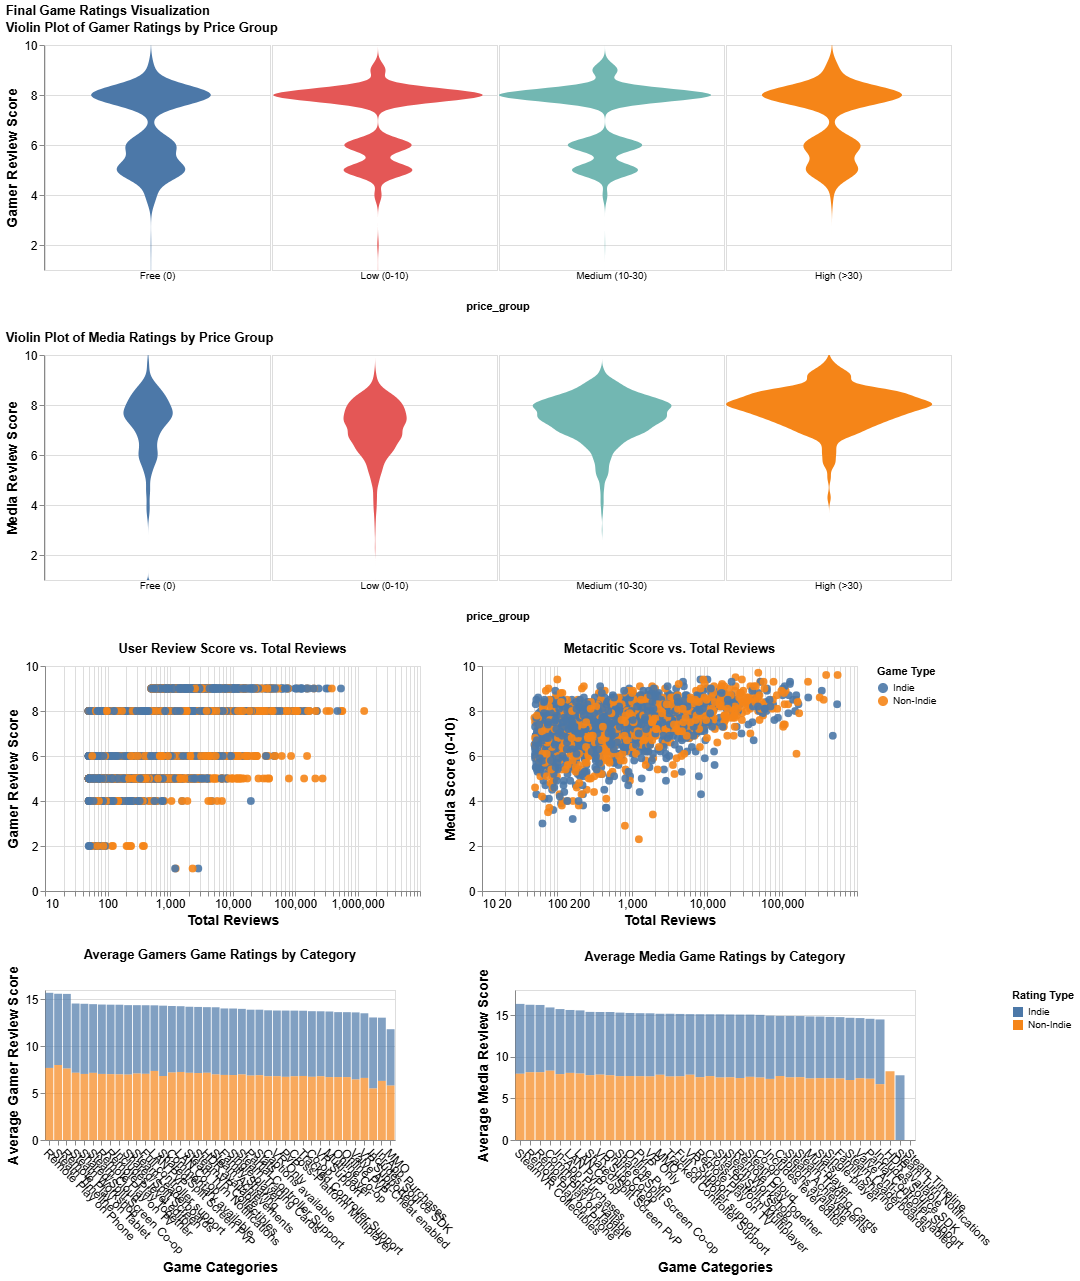

In [27]:
final_visualization = alt.vconcat(
    violin_final,
    scatter_final,
    bar_final
).resolve_scale(
    color='independent'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).properties(
    title="Final Game Ratings Visualization"
)

final_visualization

### ZiXun Fang

#### Tasks: Cluster, Find Anomalies, Compare

The violin plot successfully cluster games into four price tiers: free, low, medium and high. These plots reveal rating distributions within each price group, making readers easy to identify similar scoring structure and compare differences in reviews between gaming medias and players.

All three visualizations don't directly accomplish this task, but we can find violin distributions of those games that have extreme values (e.g. average gamer review <= 2 or total number of reviews > 100000) by using brush in scatterplots. 

All three visualizations accomplish compare tasks. Violin plots focus on the comparison between different price groups. We can compare the difference in gamer ratings between different price groups of games, and we can also compare the difference in gamer ratings and media ratings for the same price group. Scatterplot and barchart focus on comparing the difference between gamer ratings and media ratings for indie and non-indie games. Scatterplot also looks at the link between ratings and game popularity.

#### Research Question 1: How do rating distributions from users and gaming media compare across different price tiers, and what does this reveal about valuation of games at various price points?

The goal of this visualization is to explore how game ratings from both users and media vary across different price tiers.

I chose violin plots because they provide rich information about distribution shapes that simple bar charts or box plots couldn't capture. The violin's width at any given y-value represents the density of observations at that rating, making it easy to identify rating clusters. For marks, I used area marks to show distribution density, while y-axis encodes the primary quantitative variable (rating scores). Horizontal position separates the four price categories, and color distinguishes between price tiers for additional visual reinforcement.

The interactive components allow readers to further explore these relationships. The brush selection on scatter plots filters these violin plots to show distributions for specific subsets of games. The indie/non-indie radio buttons enable comparing how these price-rating relationships differ between indie and non-indie titles.

The chart could be improved by adding reference lines for median values. It would make direct comparisons between price groups more precise, but I haven't figured out how to add layers in each plot.

#### Research Question 2: Is there a significant difference in gamers and gaming media ratings across different game categories, and how does this vary between indie and non-indie games?

I designed bar charts that display average ratings for different game categories, with color encoding distinguish between indie and non-indie games. The reason I chose the bar chart is that it helps readers to clearly see the difference between gamer ratings and media ratings for the same game category, and the trend of ratings for all game categories in the respective ratings. 

The bar charts use rectangle marks with vertical position encoding the average rating and horizontal position representing different game categories. Interactive elements include category hover highlighting, which emphasizes specific categories across both charts when hovering, and the indie/non-indie filter that shows how ratings change when focusing on specific game types. These interactions can direct the reader's attention to key comparisons.

The current visualization has limitations in the readability of category labels due to their diagonal orientation and overlap. One possible improvement is to use drop-down to display fewer categories at a time. Another way is to set a width slider for the bar chart to improve readability.

#### Research Question 3: Is there a significant difference in how gamers and gaming media rate indie games compared to non-indie games across different levels of popularity as measured by total review counts?

The goal of this visualization is to explore the relationship between game popularity (as measured by the total number of reviews) and ratings. The scatterplot helps the reader to clearly see if there is a clear trend between the total number of reviews and the game ratings. Unfortunately, according to the scatterplot we can see that there is no clear relationship between game popularity and ratings, and that the ratings of some games that are continuously updated may change due to new content.

The review count slider filters games by popularity, allowing examination of rating patterns across different popularity thresholds. The brush selection enables focusing on specific regions of the popularity-rating space, with those selections propagating to the violin plots. Additionally, the year slider allows temporal filtering to account for potential rating trends over time. Games that do not meet the threshold are made transparent to allow readers to better focus on the games they filter out. These interactions are important in this plot because they also affect other visualizations to analyze different scenarios.

The scatterplot could be further optimized, for example by adding separate trend lines for indie and non-indie games to more clearly show the differences in scoring patterns.